<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">

## QSAR-based classification of molecular toxicity using Chemical descriptors, Molecular Fingerprints and Random Forest.

**Goal** Train and evaluate a multi-task classifier (e.g., LogisticRegression, RandomForest, XGBoost classifier) to identify toxic v non-toxic molecules (for a given assay). The input is given by a set of physicochemical descriptors or/and the fingerprints representing such modecule.

**QSAR** (Quantitative Structural-Activity Relationship): Bulding a quantitative relationship between molecular structure (e.g., molecular fingerprints or descriptors) and biological function (e.g., toxicity, activity, solubility)
</div>

<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">
    
**Training dataset** : goal is to predict chemical toxicity using computational methods - such as QSAR, ML, deep learning. Widely used in ChemInfo, has diverse chemical space.

* ~7,800 molecules represented by SMILES strings, each with the outputs from 12 binary classification assays. Labels are either 1 = active, 0 = inactive or NaN = not tested

* Assays include nuclear receptor signaling pathways (7 assays) and stress response pathways (5 assays)
</div>

<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">
    
**Tools**
* `scikit-learn` and `pandas`
* **Core cheminfo**: `RDKit` **smiles, descriptors, fingerprints** to automate molecular representation and generate the input to the classifier
* **evaluation/interpretation metrics**: accuracy, recall, f1, precision, confusion matrix, **ROC-AUC**
</div>

In [23]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from sklearn.multioutput import MultiOutputClassifier

import xgboost as xgb
import os

# Set global font sizes across the notebook
mpl.rcParams['axes.titlesize'] = 18       # Title font size
mpl.rcParams['axes.labelsize'] = 16       # Axis label font size
mpl.rcParams['xtick.labelsize'] = 14      # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 14      # Y-axis tick label font size
mpl.rcParams['legend.fontsize'] = 16      # Legend font size
#mpl.rcParams['figure.titlesize'] = 16     # Figure title size

# Tox21 da MoleculeNet, downloaded from the internet, sicne the original link/url comes with restrictions
dataset = os.path.join('data', 'tox21.csv')
df = pd.read_csv(dataset)

# Print columns
print(list(df.columns))  # print first few databse columns (SMILES + target)

print('Number of molecules in dataset = ' + str(df.shape[0]))
print('Number of assays available for classification tasks = ' + str(df.shape[1]-2))

['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53', 'mol_id', 'smiles']
Number of molecules in dataset = 7831
Number of assays available for classification tasks = 12


In [24]:
def compute_descriptors(mol):
    
    """ Helper function: compute descriptors from mol object, as from SMILES representation 
        There are human-readable, interpretable and carry physicochemical information

        INPUT: mol (RDKit representation), molecular representation from parsed SMILES string
        OUTPUT: desc, dictionary of physico-chemical properties and their values
    """
 
    desc = {}
    desc['MolWt'] = Descriptors.MolWt(mol)        # here we know the "Descriptors" functions commands explicitly
    desc['LogP'] = Descriptors.MolLogP(mol)
    desc['NumHDonors'] = Descriptors.NumHDonors(mol)
    desc['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
    desc['TPSA'] = Descriptors.TPSA(mol)
    desc['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
    
    return desc

# Compute ECFP4 fingerprint (bit vector), Morgan fingerptins with a radius of 2
def compute_ecfp4(mol, nBits=2048):
    
    """ Compute 2048 bit fingerprints out of mol
        These are not human readable, not easily interpretable; but capture struturals subgraphs info

        INPUT: mol (RDKit representation), molecular representation from parsed SMILES string
        OUTPUT: arr, binary array of size 2048 with the fingerprint representation
    """
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=nBits)
    arr = np.zeros((1,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# featurizer: prepare features for the regression
def featurizer(smiles_list):
    
    """ Take in list of SMILES representation for different molecules, and return Chem descriptors &
        Fingerprints representations
    
        OUTPUT: * features (dict), dictionary of features 
                * valid_feature_idx (list), list of indexes of molecules that are legit (not Nan!)
    """
    
    features = []
    valid_feature_idx = []
    
    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol:
            desc = compute_descriptors(mol)   # this is a dictionary already
            fp = compute_ecfp4(mol)
            desc.update({f'ECFP_{j}': fp[j] for j in range(len(fp))})   # add fingerprint dictionary entries
            features.append(desc)
            valid_feature_idx.append(i)
        else:
            print(f"Invalid SMILES skipped: {smi}")
    return features, valid_feature_idx

In [25]:
def grid_search(model, param_grid):

    """ Run grid search on model hyper-parameters to identify the best model, return the best model object
    
        INPUT: model, estimator object (for instance a scikit-learn object)
            param_grid, dictionary of the model hyperparameters we would like to tune
        OUTPUT: best model out of all screened ones (according to cv)
    """
    
    print('Running ' + str(model) + ' for fitting...')
    # Grid search with 5-fold cross-validation: this is built-in in scikit-learn
    grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,   # dictionary
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1,
                           verbose=1)
    # Fit the model
    grid_search.fit(X_train, y_train)

    # extract best model
    best_model = grid_search.best_estimator_

    # # test BEST MODEL model on test_set
    y_pred = best_model.predict(X_test)

    # run cross validation on the full dataset
    scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc') 
    print("Cross-Validation AUC scores:", -scores)  # negate because sklearn returns negative RMSE
    print("Mean AUC: {:.3f} ± {:.3f}".format(-scores.mean(), scores.std()))

    print("Best Parameters:", grid_search.best_params_)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # extract best estimator/best model out of those tested
    return best_model, y_pred

<div style="background-color: lightgreen; padding: 10px; border-radius: 5px;">

User shall choose the regressor and its parameter_grid

</div>

In [26]:
### select regressor and parameters here

regressors = {"RandomForestClassifier": RandomForestClassifier(class_weight = 'balanced', random_state=42),
              "LogisticRegression": LogisticRegression(random_state=42)}

param_grid = {"RandomForestClassifier": {'n_estimators': [10,25,50,100,200,300]},
             "XGBoost": {'n_estimators': [100, 300],
                         'max_depth': [5, 10, None],
                         'min_samples_split': [2, 5],
                         'min_samples_leaf': [1, 3],
                         'max_features': ['sqrt', 'log2'],
                         },
             "LogisticRegression": {'max_iter': [1000, 2000, 5000]}}

In [27]:
regres_model = "RandomForestClassifier"
task = 'SR-MMP'

if task not in list(df.columns):
    print('acthung! there is no such classification task in the input file')

<div style="background-color: lightgreen; padding: 10px; border-radius: 5px;">

#### Featurization, prepare X and y for the regression

(features may missing, so may the classification task result)

</div>

In [8]:
smiles_list = df['smiles'].values   #list of smiles representations for the molecules in the dataset

# Prepare features dataframe: appending descriptors & fingerprints, all together; both continuous and discrete vars
features, valid_idx = featurizer(smiles_list)
    
# convert to pd Dataframe: features is a list of dictionaries: to preseve column identity and labels
X = pd.DataFrame(features)
feature_names = list(X.columns)

# Prepare features (X_task) and (classification) labels (y_task), by removing NaNs
# a given assay might have been inconclusive (NaN) for a given molecule; remove those molecules
y = df[task]
y = y[valid_idx]   # important to only retain legit/valid molecules
print(X.shape, y.shape)

# clean the labels
y = y.dropna()

X_task = X.loc[y.index]
y_task = y.astype(int).values

assert X_task.shape[0] ==  len(y_task)

[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerator
[11:34:02] DEPRECATION WARNING: please use MorganGenerat

(7831, 2054) (7831,)


<div style="background-color: lightyellow; padding: 10px; border-radius: 5px;">

####  BONUS: Plot fingerprints using PCA

</div>

(7831, 20)


Text(0, 0.5, 'Second PCA coordinate')

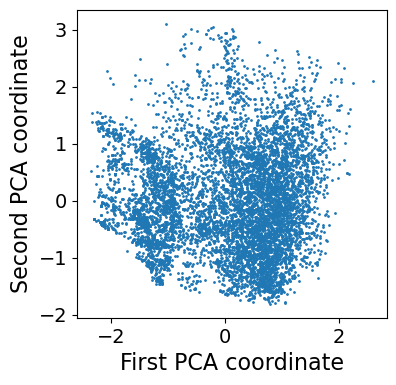

In [12]:
from sklearn.decomposition import PCA

# Separate fingerprints from descriptors
fp_cols = [col for col in X.columns if col.startswith('ECFP_')]
desc_cols = [col for col in X.columns if not col.startswith('ECFP_')]

X_fp = X[fp_cols]
X_desc = X[desc_cols]

# Apply PCA to fingerprints, we can only run PCA on high dimensional data
pca = PCA(n_components=20)  # try 20–100 components
X_fp_pca = pca.fit_transform(X_fp)

print(X_fp_pca.shape)
fig = plt.figure(figsize = (4,4))
plt.plot(X_fp_pca[:,0], X_fp_pca[:,1], 'o', markersize = 1)
plt.xlabel('First PCA coordinate')
plt.ylabel('Second PCA coordinate')

<div style="background-color: lightgreen; padding: 10px; border-radius: 5px;">

####  Optimize regressor and make predictions
</div>

In [28]:
# split data into training and test set (use scikit-learn)
X_train, X_test, y_train, y_test = train_test_split(X_task, y_task, test_size=0.2, random_state=42)

# grid search 
best_model, y_pred = grid_search(regressors[regres_model], param_grid[regres_model])

joblib.dump(best_model, os.path.join('models', regres_model + "_model_" + task + ".joblib"))

Running RandomForestClassifier(class_weight='balanced', random_state=42) for fitting...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 300}
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       981
           1       0.88      0.43      0.57       181

    accuracy                           0.90      1162
   macro avg       0.89      0.71      0.76      1162
weighted avg       0.90      0.90      0.89      1162



['models/RandomForestClassifier_model_SR-MMP.joblib']

In [29]:
print('Evaluation metrics for the best-fitting classificator:')
# compute a number of metrics that are then featured in the confusion matrix
print(" Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("   Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print(" F1 Score: {:.2f}".format(f1_score(y_test, y_pred)))

Evaluation metrics for the best-fitting classificator:
 Accuracy: 0.95
Precision: 0.56
   Recall: 0.24
 F1 Score: 0.34


<div style="background-color: lightgreen; padding: 10px; border-radius: 5px;">

####  Plot confusion matrix of the classification
</div>

Plot confusion matrix relating to the classification...


<Figure size 400x400 with 0 Axes>

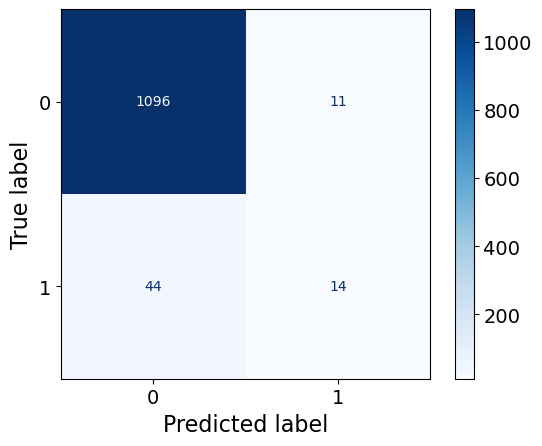

In [30]:
# Plot confusion matrix
print('Plot confusion matrix relating to the classification...')
fig = plt.figure(figsize = (4,4))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')
plt.savefig(os.path.join('plots', 'Confusion_matrix_' + regres_model + '.pdf'), bbox_inches = 'tight')

<div style="background-color: lightgreen; padding: 10px; border-radius: 5px;">

#### Build the ROC curve and compute the AUC score

</div>

In [37]:
# We can automatically compute the predicted probabilities, before thresholding to 0 or 1
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute the AUC
roc_auc = auc(fpr, tpr)

from sklearn.metrics import average_precision_score

print("PR AUC (Average Precision):", average_precision_score(y_test, y_proba))

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Toxicity classification, ' + task + ' task')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join('plots', 'roc_auc_' + regres_model + '.pdf'), bbox_inches = 'tight')

PR AUC (Average Precision): 0.41214484955705083


NameError: name 'stop' is not defined

<div style="background-color: lightgreen; padding: 10px; border-radius: 5px;">

#### Analyze importance features

</div>

Only showing the most significant 10 features


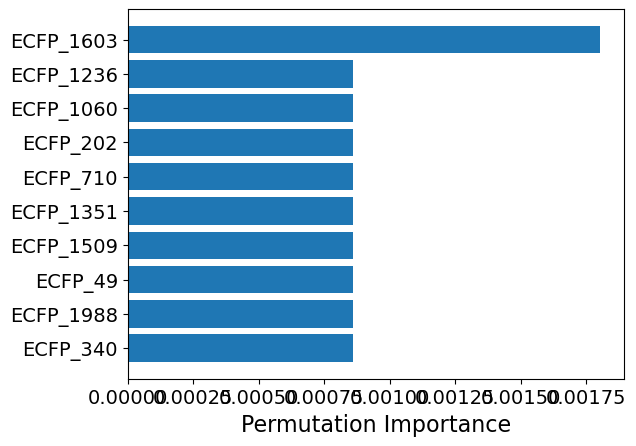

In [36]:
# permutation importance for model-agnostic importance
top_n = 10
print('Only showing the most significant ' + str(top_n) + ' features' )

# results is an object with many attributes
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[-top_n:] 
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

<div style="background-color: lightyellow; padding: 10px; border-radius: 5px;">

#### BONUS: multi-label classification

(one could actually run a loop over all the tasks and run classification sequentially; that would optimize each task single-handedly)

</div>

In [32]:
X = pd.DataFrame(features)
feature_names = list(X.columns)

In [33]:
tasks = [task for task in df.columns if ((task != 'mol_id') and (task != 'smiles'))]
assert len(tasks) == 12

# take care of the NaNs
y_all = df[tasks].dropna()
X_all = X.loc[y.index]
print(X.shape, y.shape)

(7831, 2054) (3079, 12)


In [34]:
# go get best_model and wrap it
multi_target_model = MultiOutputClassifier(best_model)

# split data into training and test set (use scikit-learn)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
multi_target_model.fit(X_train, y_train)   

(2463, 2054) (2463, 12)


MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=300,
                                                       random_state=42))

In [42]:
# Get list of predicted probabilities (1 per task)
pred_proba_list = multi_target_model.predict_proba(X_test)
# For binary classification: extract prob of class 1 (positive class) for each task
# This gives an array of shape (n_samples, n_tasks)
import numpy as np

y_pred_proba = np.array([proba[:, 1] for proba in pred_proba_list]).T

[[0.99       0.01      ]
 [0.94333333 0.05666667]
 [0.97       0.03      ]
 [0.99666667 0.00333333]
 [0.99       0.01      ]]


In [38]:
for i, task in enumerate(tasks):
    auc = roc_auc_score(y_test.iloc[:, i], y_pred_proba[:, i])
    print(f"{task}: ROC AUC = {auc:.3f}")

NR-AR: ROC AUC = 0.732
NR-AR-LBD: ROC AUC = 0.739
NR-AhR: ROC AUC = 0.799
NR-Aromatase: ROC AUC = 0.790
NR-ER: ROC AUC = 0.572
NR-ER-LBD: ROC AUC = 0.617
NR-PPAR-gamma: ROC AUC = 0.858
SR-ARE: ROC AUC = 0.672
SR-ATAD5: ROC AUC = 0.998
SR-HSE: ROC AUC = 0.686
SR-MMP: ROC AUC = 0.867
SR-p53: ROC AUC = 0.825
